### Note:
- This notebook only process three types of experiment data which are:
1. EMG measurement from three channels
2. Elbow flexion / extension

In [1]:
import os
import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn

import scipy
from scipy import signal
from scipy.signal import freqz

import math

### Prepare the functions of filter

In [54]:
def full_wave_rectify(signal):
    rectify_emg = np.absolute(signal)
    return rectify_emg
    
def band_pass(signal, fs = 2000, high_band = 1000, low_band = 10, order = 4):
    """
    signal: rectified EMG data
    high_band: high pass filter cut off frequency
    low_band: low pass filter cut off frequency
    fs: sampling frequency
    order: order of filter
    """
    # normalize cut-off frequency by sampling frequency
    high_band = high_band / (fs)
    low_band = low_band / (fs)
    # create bandpass filter gain
    b, a = scipy.signal.butter(order, [low_band, high_band], btype='bandpass', analog = False)
    
    # Filter EMG 
    emg_bandpass = scipy.signal.filtfilt(b, a, signal, padlen = 1)
    return emg_bandpass

def low_pass(signal, fs = 2000, low_pass = 10, order = 4, axs = -1, padB = False, pad = 0):
    """
    signal: rectified EMG data
    low_pass: low pass filter cut off frequency
    fs: sampling frequency
    order: rder of filter
    """
    
    # normalize cut-off frequency
    low_pass = low_pass / (fs / 2)
    #create lowpass filter
    b, a = scipy.signal.butter(order, low_pass, btype = 'lowpass', analog = False)
    
    if padB:
        emg_envelop = scipy.signal.filtfilt(b, a, signal, padlen = pad, axis = axs )
    else:
        emg_envelop = scipy.signal.filtfilt(b, a, signal, axis = axs)
        
    return emg_envelop

def high_pass(signal, fs = 2000, high_pass = 10, order = 4):
    """
    signal: rectified EMG data
    high_pass: high pass filter cut off frequency
    fs: sampling frequency
    order: order of filter
    """
    
    high_pass = high_pass / (fs / 2)
    b, a = scipy.signal.butter(order, high_pass, btype = 'highpass')
    emg_envelop = scipy.signal.filtfilt(b, a, signal, padlen = 1)
    return emg_envelop
    

### Prepare feature extraction functions

In [55]:
a = np.arange(10, 5831, 10)
j = 0
for i in range(len(a)):
    j += 1
print(j)

583


In [56]:
def getEMGfeatures(emg, window = 1, step = 1):
    """
    emg: filtered rectified EMG signal
    window: size of sliding windows
    step: number of step between two windows
    """
    endPt = len(emg)
    pts = np.arange(window, endPt, step)
    j = 0
    for i in range(len(pts)):
        j += 1
        sampleEMG = emg[pts[i] - window + 1:pts[i], :]
        pass
        
    
def getfeaturesTD(emg):
    pass
    

### Data Preprocessing
1. Full-wave rectification
2. Remove the noise from data by using Butterworth Filter
3. Feature extraction
4. Dimensionality Reduction (*Optional)
5. Save the data as '.csv' file

In [57]:
# Setup the parameters of signal
fs = 2000

In [58]:
# path = r'/home/jerry/GitHub/EMG_regressive_model/data_process/raw_data'
path = r'D:/GitHub/EMG_regressive_model/data_process/raw_data'
all_files = glob.glob(path+'/*.csv')
dfList = []

In [59]:
# Read .csv file by using panda
# for filename in all_files:
file = all_files[0]
saveName = file[-11:-4]
print(file)
allData = pd.read_csv(file, skiprows = 4, header = None)


D:/GitHub/EMG_regressive_model/data_process/raw_data\2021-06-08-13-13_CUBE elbow data collection_2.75_T_1.csv


In [66]:
# Create the dataframe for EMG data and Joint angle
emgData = allData.iloc[:, 3:6]
angleData = allData.iloc[:, 32:33]

#Convert the dataframe to numpy array
emg = emgData.to_numpy()
time = np.array([i/2000 for i in range(0, len(emg), 1)]) # sampling rate 2000 Hz
mean = np.mean(emg, axis = 0)
emgAvg = emg - mean

angle = angleData.to_numpy()
# Perform the full wave rectification
rectEmg = full_wave_rectify(emgAvg)
bpEmg = band_pass(rectEmg, 2000, 1000, 10, 4)
features = getEMGfeatures(bpEmg, window = 10, step = 10)
print(len(angle))
print(len(bpEmg))
angle.shape[0] - 1
bpAngle = low_pass(angle, fs = 2000, low_pass = 250, order = 4, axs = 0, padB = False, pad = 0)
# print(len(rectEmg))
# print(bpEmg.shape)
# highEmg = high_pass(rectEmg, order = 8, high_pass = 15, fs = 2000)
# lowEmg = low_pass(highEmg, order = 4, low_pass = 1000, fs = 2000)

53200
53200


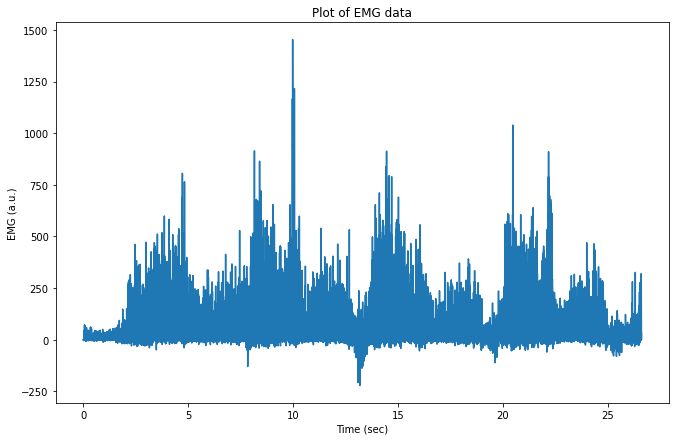

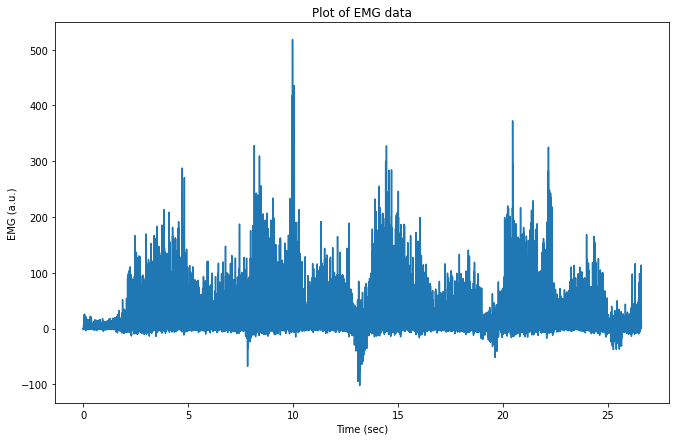

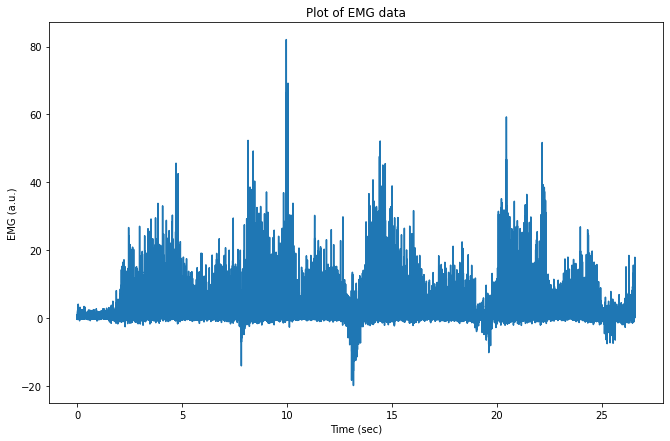

In [67]:
for i in range(3):
    fig = plt.figure()
    plt.plot(time, bpEmg[:, i])
    plt.xlabel('Time (sec)')
    plt.ylabel('EMG (a.u.)')
    plt.title('Plot of EMG data')
    fig_name = 'Filt'+str(i)+'.png'
    fig.set_size_inches(w=11,h=7)
    fig.savefig(fig_name)

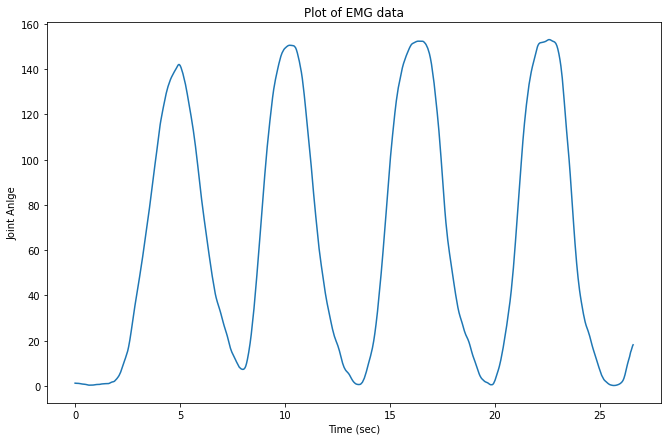

In [68]:
fig = plt.figure()
plt.plot(time, angle)
plt.xlabel('Time (sec)')
plt.ylabel('Joint Anlge')
plt.title('Plot of EMG data')
fig_name = 'Angle1.png'
fig.set_size_inches(w=11,h=7)
fig.savefig(fig_name)

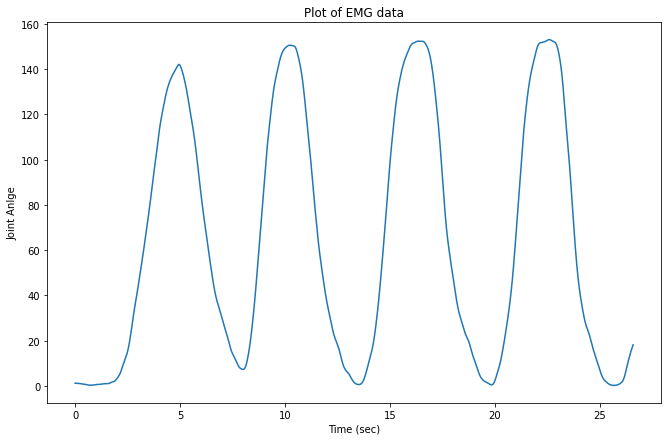

In [69]:
fig = plt.figure()
plt.plot(time, bpAngle)
plt.xlabel('Time (sec)')
plt.ylabel('Joint Anlge')
plt.title('Plot of EMG data')
fig_name = 'Angle2.png'
fig.set_size_inches(w=11,h=7)
fig.savefig(fig_name)